<a href="https://colab.research.google.com/github/Mohamedalaadin/Electric_Vehicle_Charging/blob/main/Electric_Vehicle_Charging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Analysis and Forecasting of kWh Consumption**

**Introduction**

**Problem Definition**

In this project, we aim to forecast the total energy consumption (in kWh) from a dataset of electric vehicle (EV) charging sessions. Accurate forecasting of energy consumption is crucial for efficient energy management and planning in EV charging stations. This can help in optimizing the energy supply, managing loads, and ensuring that the charging infrastructure operates smoothly.

**Dataset Description**

The dataset used for this project is sourced from Kaggle and contains detailed information on electric vehicle charging sessions. It includes data from 3,395 high-resolution charging sessions from 85 EV drivers at 105 stations across 25 sites. These sites are part of a workplace charging program under the U.S. Department of Energy's workplace charging challenge. The data is available in CSV format and can be found at the following link: [Electric Vehicle Charging Dataset on Kaggle](https://www.kaggle.com/datasets/michaelbryantds/electric-vehicle-charging-dataset/code?datasetId=2597433&sortBy=voteCount).

**Objective**

The primary objective of this analysis is to develop a model that can accurately predict the total energy consumption (kWh) for future time periods based on historical data. Given the dataset’s time span of less than a year, we also need to address challenges related to seasonality and potential data trends.

#Approach (Thinking Path)

**Initial Thoughts and Planning**

When I first received the dataset and the task of forecasting the total energy consumption (kWh), I recognized the need for a systematic and methodical approach. Understanding that the data spans less than a year, I anticipated challenges in detecting seasonality. Therefore, I planned to take the following steps to ensure a thorough analysis and accurate forecasting:

**1.Data Understanding and Preparation**

- **Initial Data Loading**: My first step was to load the dataset into a pandas DataFrame to explore its structure and content.
-**Data Cleaning**: I expected some missing or inconsistent values, so I prepared to handle these issues by checking for null values and ensuring proper data types. However, I found that there were no missing values except in the *distance column*.
-**Date-Time Conversion**: Given the importance of time series data, I planned to convert the relevant columns into a datetime format.

**2.Exploratory Data Analysis (EDA)**

- **Descriptive Statistics**: I started with basic descriptive statistics to get an overview of the data distribution, central tendencies, and variability.
-**Visual Analysis**: Using plots and graphs, I aimed to visualize the data to identify trends, patterns, and potential outliers. This included time series plots for kWh consumption.
-**Outlier Detection**: Through box plots and scatter plots, I intended to identify and handle outliers that could skew the analysis, especially in the kwhTotal.

**3.Feature Engineering**

- **Lag Features**: To capture temporal dependencies, I planned to create lagged versions of the kWh consumption data.
-**Day of the Week Analysis**: Recognizing that energy consumption might vary by day of the week, I added one-hot encoded features for each day. This insight was particularly useful as I discovered that kWh consumption during weekends was generally lower.
-**Charge Time Hours**: As charge time might influence energy consumption, I included this feature after resampling it to match the kWh data's frequency.

**4.Handling Missing Values**

- **Rolling Mean Imputation**: Initially, I considered using rolling means to fill in any gaps in the data. This method leverages the local mean, which can be more reliable than global mean imputation. I made plots to identify the best window size for the rolling mean (3, 7, and 30 days) and determined that a 7-day window was optimal for capturing trends without being too sensitive.
-**Validation**: After filling missing values, I validated the results to ensure the imputation did not introduce bias.

**5.Model Selection and Training**

- **Model Exploration**: I explored several models, starting with AutoReg and ARIMA due to their suitability for time series data. Understanding that ARIMA requires stationary data, I checked and transformed the data accordingly.
-**Feature Addition**: Given the small dataset, I decided to enhance the model by adding more features (7-day lags, day of the week flags, and charge time). The correlation matrix was instrumental in selecting the most relevant features.
-**Alternative Models**: I tried different models including Linear Regression, XGBoost, and Random Forest, which provided better results due to the enriched feature set.

**6.Hyperparameter Tuning**

-**Grid Search**: For models like Random Forest and XGBoost, I used Grid Search for hyperparameter tuning to find the optimal model configuration.


**7.Forecasting and Evaluation**

- **Walk-Forward Validation**: To mimic real-world forecasting, I used walk-forward validation for testing the model, which involves training on past data and predicting the next time step iteratively.
-**Performance Metrics**: I evaluated the model using metrics such as Mean Absolute Error (MAE) to quantify prediction accuracy.
-**Result Interpretation**: Finally, I interpreted the results, comparing the model predictions with actual values and providing insights into the energy consumption patterns.

**Implementation Steps**

Following this plan, I executed the steps as described:

- Loaded and cleaned the data, converting date columns and handling missing values.
-Conducted EDA to visualize trends and detect outliers.
-Engineered relevant features, including lag features and one-hot encoded weekdays.
-Filled missing values using rolling means and validated the imputation.
-Selected and trained models, performing hyperparameter tuning where necessary.
-Used walk-forward validation for forecasting and evaluated model performance using MAE.
-Interpreted the results and prepared the final notebook with all steps documented and visualized.

# Importing Libaraies

In [ ]:
import time
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# Data Loading and Initial Exploration

In [ ]:
dataset = '/content/drive/MyDrive/EC dataset/station_data_dataverse.csv' #Change with your dataset CSV file path

In [ ]:
df = pd.read_csv(dataset)
df.head()

,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,managerVehicle,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip
0,1366563,7.78,0.00,0014-11-18 15:40:26,0014-11-18 17:11:04,15,17,1.510556,Tue,android,...,0,3,0,1,0,0,0,0,0,0
1,3075723,9.74,0.00,0014-11-19 17:40:26,0014-11-19 19:51:04,17,19,2.177222,Wed,android,...,0,3,0,0,1,0,0,0,0,0
2,4228788,6.76,0.58,0014-11-21 12:05:46,0014-11-21 16:46:04,12,16,4.671667,Fri,android,...,0,3,0,0,0,0,1,0,0,0
3,3173284,6.17,0.00,0014-12-03 19:16:12,0014-12-03 21:02:18,19,21,1.768333,Wed,android,...,0,3,0,0,1,0,0,0,0,0
4,3266500,0.93,0.00,0014-12-11 20:56:11,0014-12-11 21:14:06,20,21,0.298611,Thu,android,...,0,3,0,0,0,1,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sessionId       3395 non-null   int64  
 1   kwhTotal        3395 non-null   float64
 2   dollars         3395 non-null   float64
 3   created         3395 non-null   object 
 4   ended           3395 non-null   object 
 5   startTime       3395 non-null   int64  
 6   endTime         3395 non-null   int64  
 7   chargeTimeHrs   3395 non-null   float64
 8   weekday         3395 non-null   object 
 9   platform        3395 non-null   object 
 10  distance        2330 non-null   float64
 11  userId          3395 non-null   int64  
 12  stationId       3395 non-null   int64  
 13  locationId      3395 non-null   int64  
 14  managerVehicle  3395 non-null   int64  
 15  facilityType    3395 non-null   int64  
 16  Mon             3395 non-null   int64  
 17  Tues            3395 non-null   i

# Data Preparation and  Resampling

Our goal is to understand , prepare  and resample the data, In this section we  will explore data structure and its content, handel missing or inconsistent values and converting the relevant columns into a datetime format.

**Missing values**

There is no missing values in all columns except for distance colum it has 1065 missing values.

In [ ]:
missing_distance = df['distance'].isna().sum()
missing_distance

1065

In [ ]:
df.describe()

,sessionId,kwhTotal,dollars,startTime,endTime,chargeTimeHrs,distance,userId,stationId,locationId,managerVehicle,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip
count,3.395000e+03,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,2330.000000,3.395000e+03,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,5.487001e+06,5.809629,0.118268,13.743446,16.455965,2.841488,18.652378,5.742395e+07,576789.678056,629934.460677,0.595582,2.428571,0.181443,0.187040,0.210015,0.216495,0.179676,0.018262,0.007069,0.703976
std,2.590657e+06,2.892727,0.492562,3.204370,3.406732,1.507472,11.420571,2.674772e+07,257486.310402,255620.993849,0.490851,0.811204,0.385442,0.390001,0.407379,0.411916,0.383974,0.133918,0.083793,0.456569
min,1.004821e+06,0.000000,0.000000,0.000000,0.000000,0.012500,0.856911,1.042767e+07,129465.000000,125372.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.234666e+06,4.350000,0.000000,11.000000,14.000000,2.110278,5.135871,3.329548e+07,369001.000000,481066.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.451498e+06,6.230000,0.000000,13.000000,16.000000,2.808889,21.023826,4.924181e+07,549414.000000,503205.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.746644e+06,6.830000,0.000000,17.000000,20.000000,3.544167,27.285053,8.188052e+07,864630.000000,878393.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.998981e+06,23.680000,7.500000,23.000000,23.000000,55.238056,43.059292,9.834581e+07,995505.000000,978130.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Converting the *created* and *ended* Columns to datetime Format**

The 'created ' and 'ended' columns in the format 00YY-MM-DD HH:MM:SS , Since the year part of your datetime string has an extra 00, we need to handle it during conversion.

In [ ]:
def convert_into_datetime_handling_extra_00(column):
    df[column] = df[column].apply(lambda x: '20' + x[2:] if isinstance(x, str) else x)  # Adjust the year
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S', errors='coerce')

convert_into_datetime_handling_extra_00('created')
convert_into_datetime_handling_extra_00('ended')

print(df[["created", "ended"]])

                 created               ended
0    2014-11-18 15:40:26 2014-11-18 17:11:04
1    2014-11-19 17:40:26 2014-11-19 19:51:04
2    2014-11-21 12:05:46 2014-11-21 16:46:04
3    2014-12-03 19:16:12 2014-12-03 21:02:18
4    2014-12-11 20:56:11 2014-12-11 21:14:06
...                  ...                 ...
3390 2015-10-01 16:31:18 2015-10-01 19:59:08
3391 2015-10-02 16:28:48 2015-10-02 19:27:05
3392 2015-09-30 16:54:22 2015-09-30 20:24:06
3393 2015-09-24 11:43:02 2015-09-24 13:55:12
3394 2015-10-01 16:43:05 2015-10-01 19:42:06

[3395 rows x 2 columns]


**Seting our data index**

We have two options to set our index either the created or ended column, Using created as the index means we are aligning our time series with the start of each event. and using ended as the index might make more intuitive sense because it captures the total consumption at the end of each session.

In [ ]:
'''#Set 'ended' as the index
df.set_index('ended', inplace=True)'''

#Edited: after seeing the results from the Correlation matrix I found a better relation between created and KwhTotal than ended and KwhTotal
# Set 'created' as the index
df.set_index('created', inplace=True)

In [ ]:
df['kwhTotal'].head()

created
2014-11-18 15:40:26    7.78
2014-11-19 17:40:26    9.74
2014-11-21 12:05:46    6.76
2014-12-03 19:16:12    6.17
2014-12-11 20:56:11    0.93
Name: kwhTotal, dtype: float64

**boxplot to Searching for outliers**

Here I am trying to make boxplot to help me identifing outliers , but as you can see there is an error and the blot not helping us.

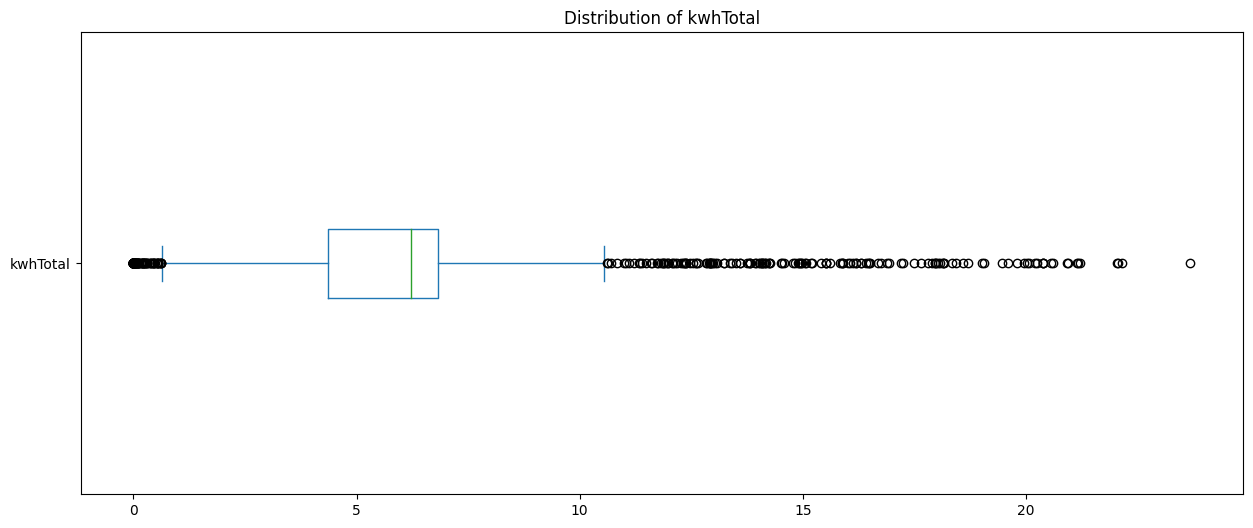

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
df['kwhTotal'].plot(kind='box', vert=False, ax=ax)
ax.set_title('Distribution of kwhTotal')
plt.show()

I did some search and I found that 90% of Kwh consumption is 16 Kwh , so we can discaed the values above 20 Kwh as we dont have alot of data.

This is the link to the [publication source](https://www.researchgate.net/figure/Charge-session-average-energy-kWh-time-minutes-and-power-kW-and-corresponding_tbl1_341263477).

In [ ]:
df_masked = df[df['kwhTotal'] < 20]
df_masked.shape

(3377, 23)

**resampling The data**

Here I'm trying to resample the data to days but the data is so small to make a forcasting model , and also there is alot of missing data about 26% of the data is missing, and this is alot to be handeled without affecting the trend of the data.

In [ ]:
df_resampled = df_masked['kwhTotal'].resample('D').sum() #you can try here to resample with H (hours) but you will find that about 84% of the data is missing
zero_kwh_total = df_resampled[df_resampled == 0]
zero_kwh_count = zero_kwh_total.count()
print(f"Number of days with zero kwh total: {zero_kwh_count}")
print(df_resampled.shape)

Number of days with zero kwh total: 85
(321,)


In [ ]:
df_resampled.head()

created
2014-11-18    13.39
2014-11-19    18.77
2014-11-20     6.95
2014-11-21    14.14
2014-11-22     0.00
Freq: D, Name: kwhTotal, dtype: float64

**Time series plot**

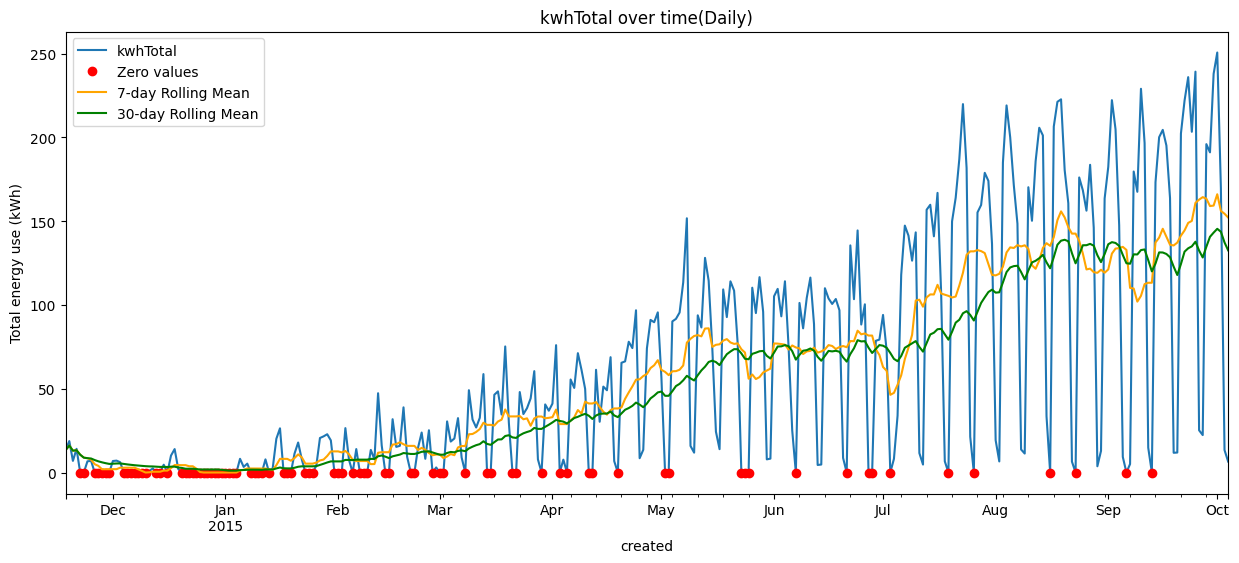

In [ ]:
rolling_mean_7 = df_resampled.rolling(window=7, min_periods=1).mean()
rolling_mean_30 = df_resampled.rolling(window=30, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(15, 6))
df_resampled.plot(xlabel="Time", ylabel="Total energy use (kWh)", title= "kwhTotal over time(Daily)",ax=ax)

# Highlight zero values with red circles
ax.plot(zero_kwh_total.index, zero_kwh_total, 'ro', label='Zero values')

# Plot the rolling means
rolling_mean_7.plot(ax=ax, label='7-day Rolling Mean', color='orange')
rolling_mean_30.plot(ax=ax, label='30-day Rolling Mean', color='green')


ax.legend()
plt.show()

As we see there is **alot of missing data** so the line is going up and down , but as we can see there is a good sgin that there is a **trend in the data** for both 7-day and 30-day.

**Filling the Missing Data**

Because we are expecting the data to have a seasonal pattern (e.g., higher consumption on certain days of the week) and there is a lot of missing values, rolling mean will be a good choise.

**Apply rolling mean**

here we using our window to 7 days as it has a trend, we are not choosing smaller number like 3days as it will be better fit to the data but it will be senstive for noise too.

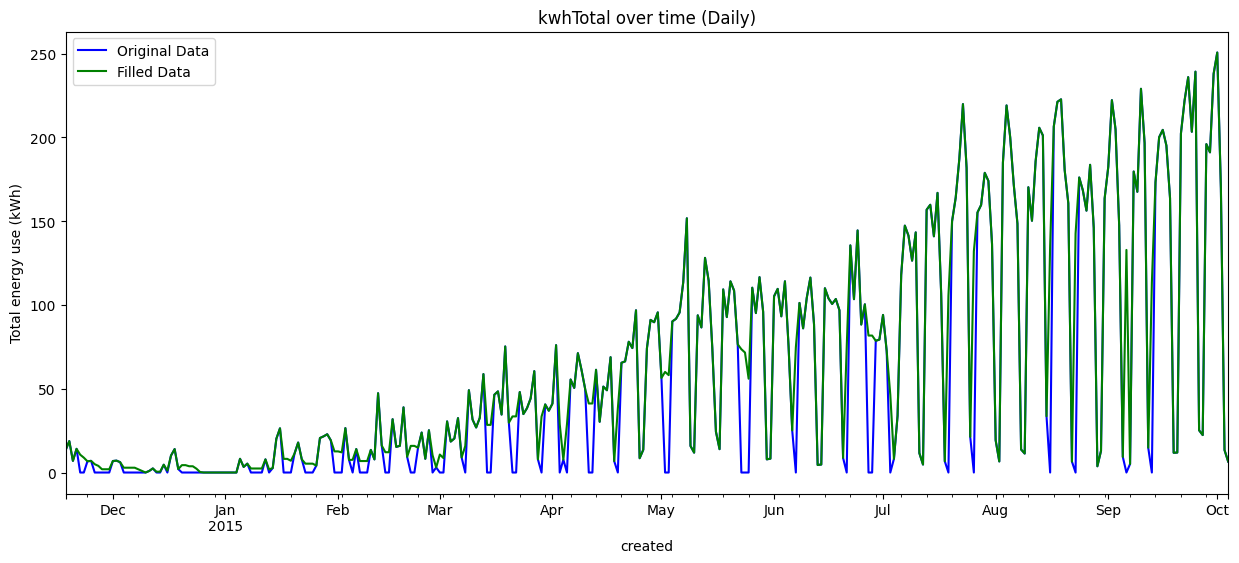

In [ ]:
# Apply a rolling mean with 7-day window
rolling_mean = df_resampled.rolling(window=7, min_periods=1).mean()

# Fill missing values with the rolling mean
df_filled = df_resampled.fillna(rolling_mean)

zero_kwh_total = df_filled[df_filled == 0]

df_filled[zero_kwh_total.index] = rolling_mean[zero_kwh_total.index] # I used the code this way as there was a problem with isna and fillna function in descovering 0 values


# Plot the filled and the original data to verify
fig, ax = plt.subplots(figsize=(15, 6))
df_resampled.plot(xlabel="Time", ylabel="Total energy use (kWh)", title="kwhTotal over time (Daily)", ax=ax, color='blue', label='Original Data')

df_filled.plot(ax=ax, color='green', label='Filled Data')


ax.legend()
plt.show()

**Validating the filled data**

In [ ]:
filled_stats = df_filled.describe()
filled_stats

count    321.000000
mean      66.694203
std       68.407605
min        0.000000
25%        8.200000
50%       34.890000
75%      109.620000
max      250.690000
Name: kwhTotal, dtype: float64

In [ ]:
df_filled.to_frame()

,kwhTotal
created,
2014-11-18,13.39
2014-11-19,18.77
2014-11-20,6.95
2014-11-21,14.14
2014-11-22,10.65
...,...
2015-09-30,237.98
2015-10-01,250.69
2015-10-02,169.80


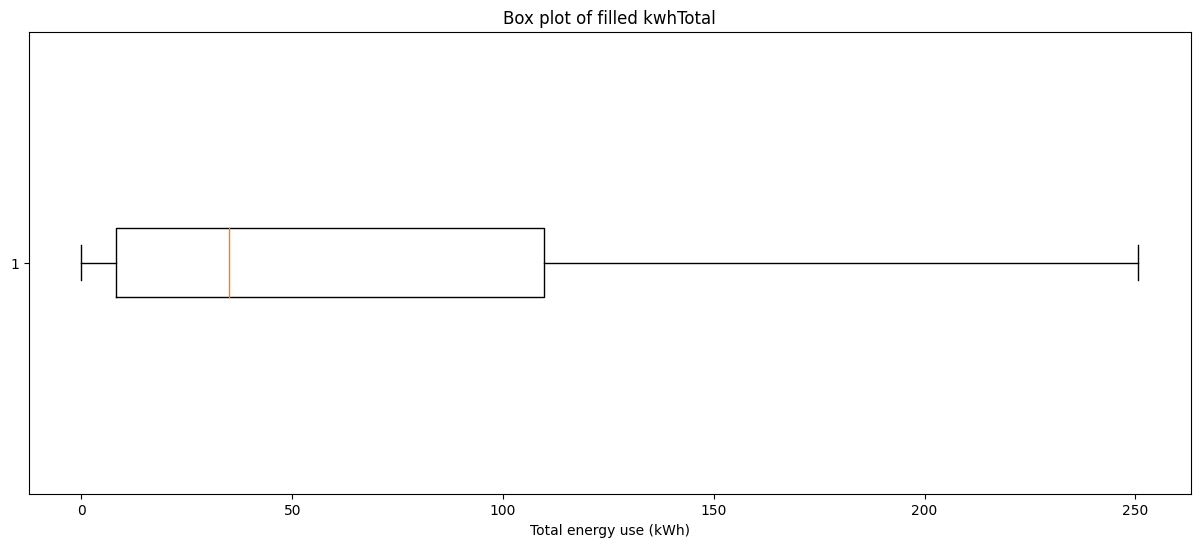

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the box plot using matplotlib
ax.boxplot(df_filled, vert=False)
ax.set_title('Box plot of filled kwhTotal')
ax.set_xlabel('Total energy use (kWh)')

plt.show()

It looks good, there is no bias in the imputed data.

# Exploratory Data Analysis (EDA)

I did some EDA in the Preparation phase as it was esensial to prepare the data , now I'm making fearther more EDA to get useful insights from the data and to help us at the Feature Engineering phase.

In [ ]:
#Summary statistics for numerical columns
summary_statistics = df.describe()
summary_statistics

,sessionId,kwhTotal,dollars,ended,startTime,endTime,chargeTimeHrs,distance,userId,stationId,...,managerVehicle,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip
count,3.395000e+03,3395.000000,3395.000000,3395,3395.000000,3395.000000,3395.000000,2330.000000,3.395000e+03,3395.000000,...,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,5.487001e+06,5.809629,0.118268,2015-07-10 21:21:55.298969088,13.743446,16.455965,2.841488,18.652378,5.742395e+07,576789.678056,...,0.595582,2.428571,0.181443,0.187040,0.210015,0.216495,0.179676,0.018262,0.007069,0.703976
min,1.004821e+06,0.000000,0.000000,2014-11-18 17:11:04,0.000000,0.000000,0.012500,0.856911,1.042767e+07,129465.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.234666e+06,4.350000,0.000000,2015-05-28 15:06:09.500000,11.000000,14.000000,2.110278,5.135871,3.329548e+07,369001.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.451498e+06,6.230000,0.000000,2015-07-24 12:48:07,13.000000,16.000000,2.808889,21.023826,4.924181e+07,549414.000000,...,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.746644e+06,6.830000,0.000000,2015-09-01 13:46:38,17.000000,20.000000,3.544167,27.285053,8.188052e+07,864630.000000,...,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.998981e+06,23.680000,7.500000,2015-10-04 15:54:06,23.000000,23.000000,55.238056,43.059292,9.834581e+07,995505.000000,...,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,2.590657e+06,2.892727,0.492562,NaN,3.204370,3.406732,1.507472,11.420571,2.674772e+07,257486.310402,...,0.490851,0.811204,0.385442,0.390001,0.407379,0.411916,0.383974,0.133918,0.083793,0.456569


In [ ]:
# Distribution of categorical variables
categorical_distribution = df.describe(include=['object'])
categorical_distribution

,weekday,platform
count,3395,3395
unique,7,3
top,Thu,ios
freq,735,2234


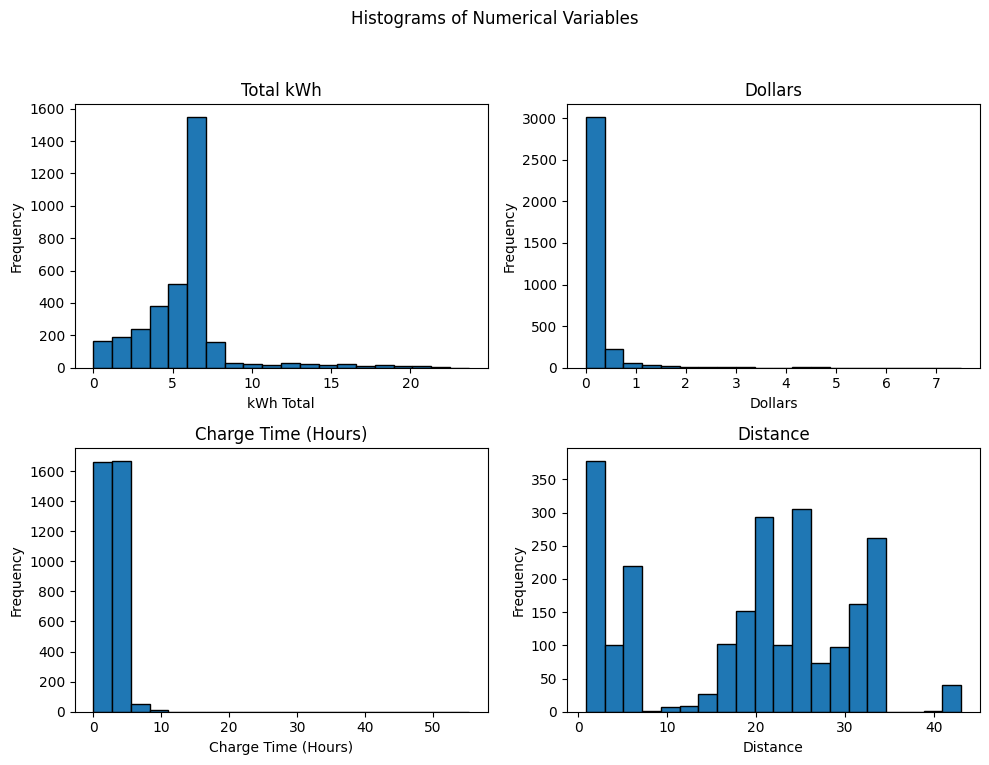

In [ ]:
# Plot histograms for numerical variables
numerical_columns = ['kwhTotal', 'dollars', 'chargeTimeHrs', 'distance']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Histograms of Numerical Variables')

# List of titles and labels for the histograms
titles = ['Total kWh', 'Dollars', 'Charge Time (Hours)', 'Distance']
x_labels = ['kWh Total', 'Dollars', 'Charge Time (Hours)', 'Distance']
y_label = 'Frequency'

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, col, title, x_label in zip(axes, numerical_columns, titles, x_labels):
    ax.hist(df[col], bins=20, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plots above show the distrabution of the numerical variables and its very useful to understand the data.

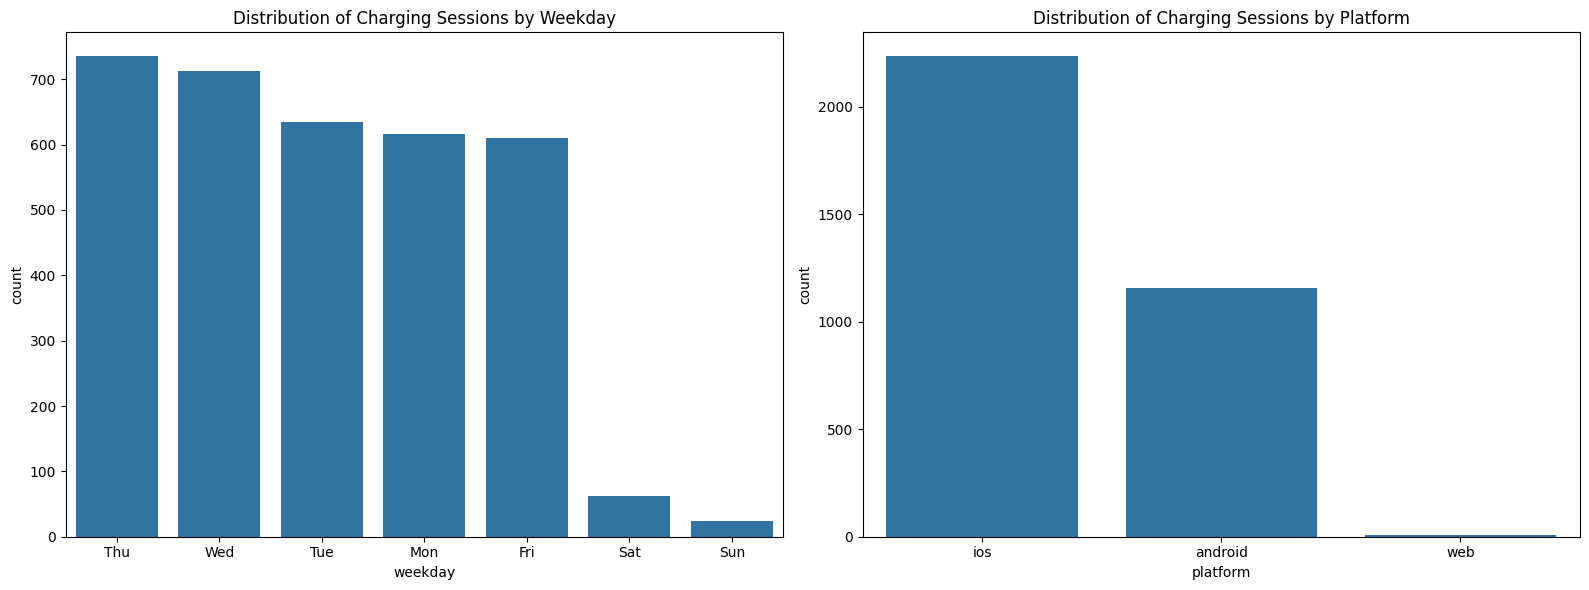

In [ ]:
# Bar plots for categorical variables
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Weekday plot
sns.countplot(data=df, x='weekday', order=df['weekday'].value_counts().index, ax=axes[0])
axes[0].set_title('Distribution of Charging Sessions by Weekday')

# platform plot
sns.countplot(data=df, x='platform', order=df['platform'].value_counts().index, ax=axes[1])
axes[1].set_title('Distribution of Charging Sessions by Platform')

plt.tight_layout()
plt.show()

We got a very good information about weekdays, as we can see that weekend days consumption is generally small and it will be a very useful feature for our model.

We found also that ios users usually higher consumption but that could be only for the smaple not for the popualtion at genreral, so if we use it will led to overfitting.

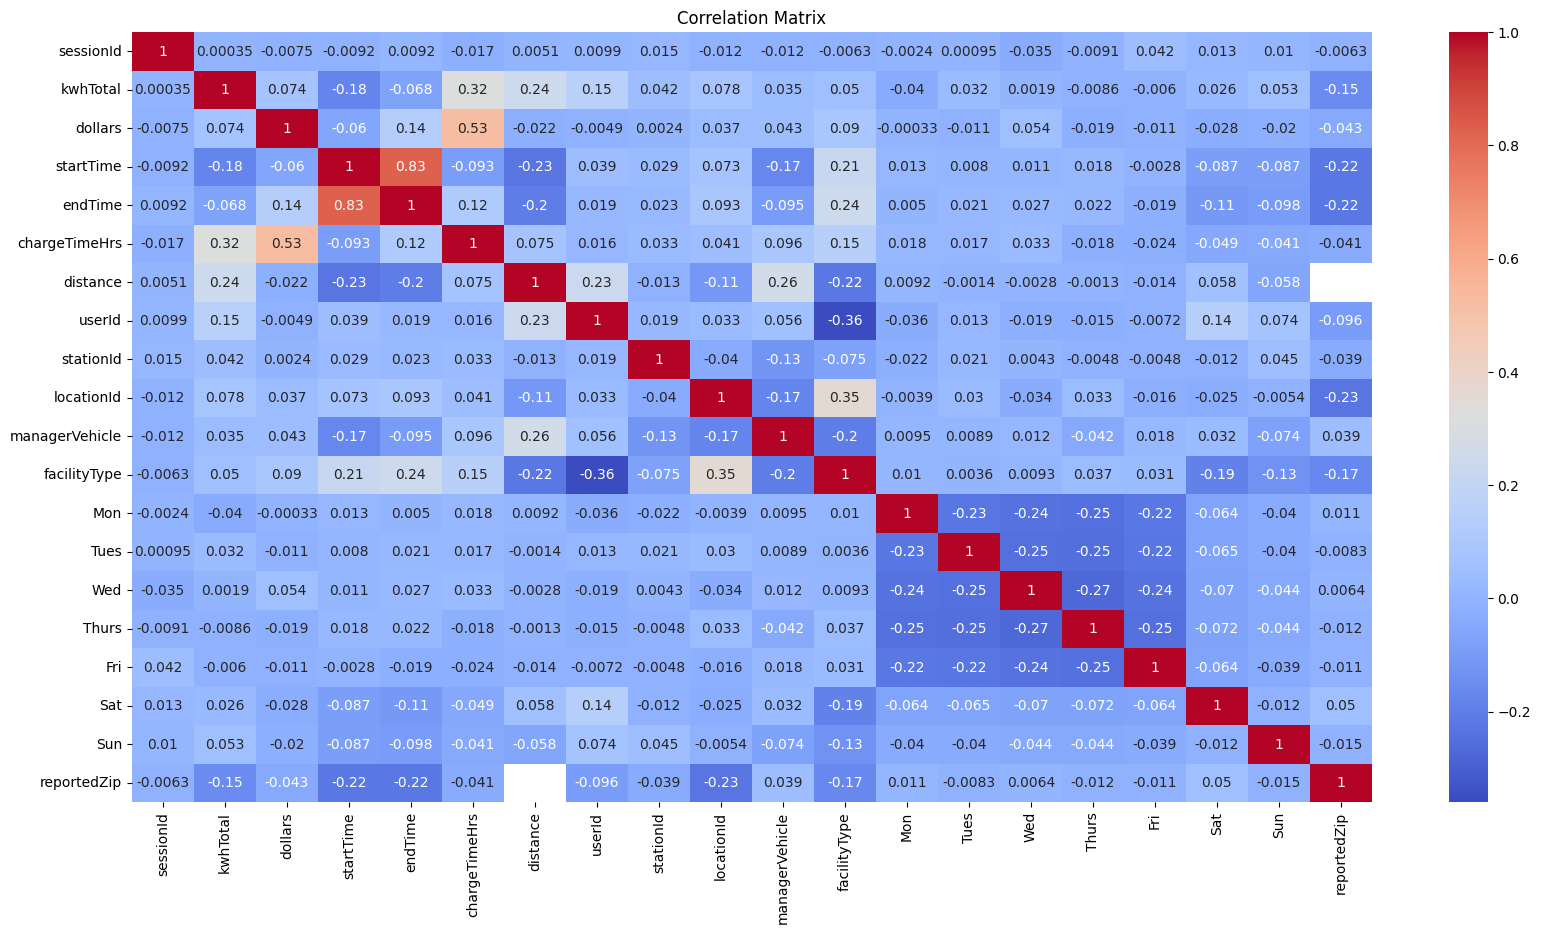

In [ ]:
# Correlation matrix for numerical columns only
numeric_data = df.select_dtypes(include=[float, int])
if not numeric_data.empty:
    correlation_matrix = numeric_data.corr()
    plt.figure(figsize=(20, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("No numeric data available to compute correlation matrix.")

The correlation matrix is a valuable tool for understanding the relationships between different columns in the dataset. By examining the correlation between the target column, kwhTotal, and other columns, we can identify the key features for our models. From the correlation matrix, we observe that chargeTimeHrs has a strong correlation with kwhTotal. Although distance also shows a high correlation, it has many missing values, so I decided not to use it in our models.

Furthermore, analyzing the correlation between feature columns themselves helps us understand how they are related to each other, enabling us to avoid multicollinearity by excluding highly correlated features from our models.

**ACF plot**

I am using the ACF plot to understand how the correlation changes with different lag values.

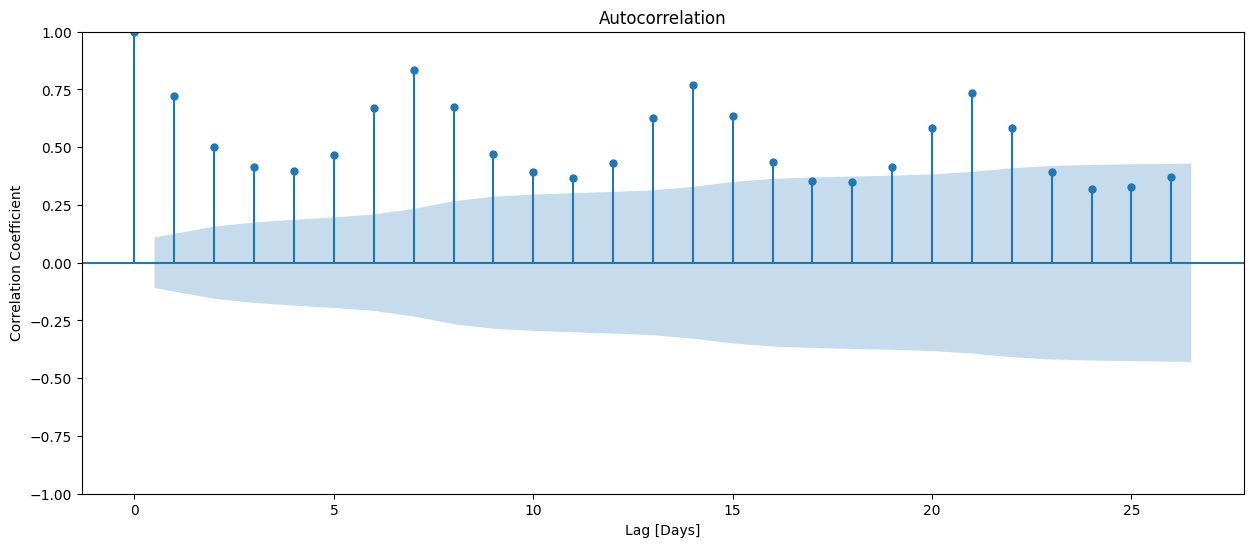

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df_filled, ax=ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

The ACF plot reveals strong correlations within the same day across different weeks, as well as notable correlations with adjacent weekdays within the same month

**PACF plot**

I am using the PACF plot to determine which lag number provides the most information that will help improve the model.

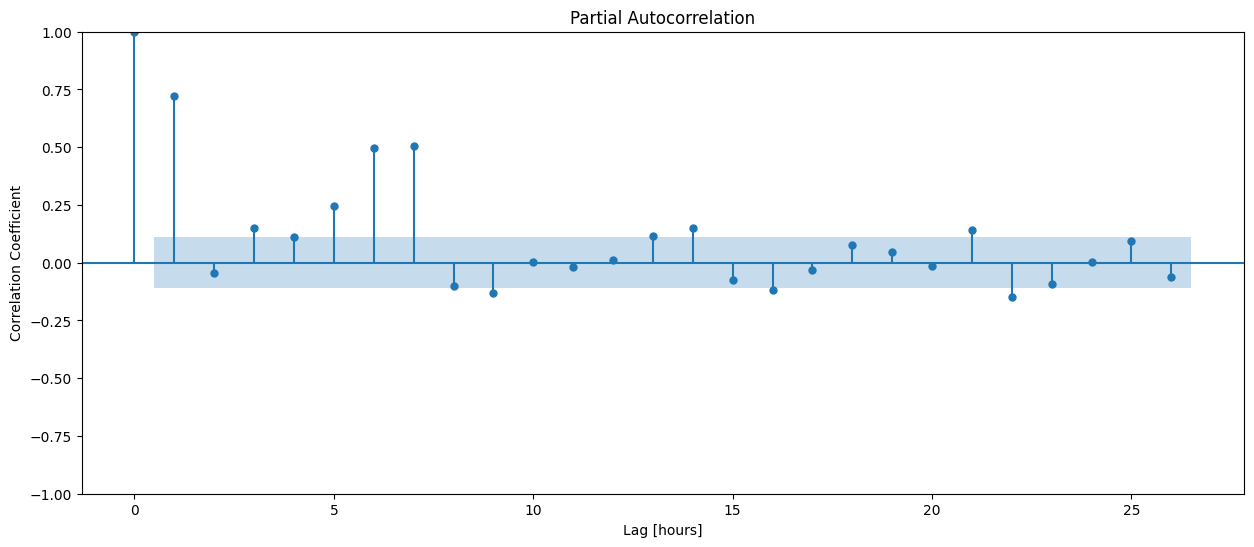

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df_filled, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

The PACF plot reveals strong partial correlation with a 7-day lag (same week).

# Split the data

In [ ]:
cutoff_test = int(len(df_filled) * 0.95)

y_train = df_filled.iloc[:cutoff_test]
y_test = df_filled.iloc[cutoff_test:]

print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

Training set size: 304
Test set size: 17


#Modeling

**Baseline Model**

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean kwhTotal:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean kwhTotal: 62.52
Baseline MAE: 54.5


# **Iterate**

# Attemp 1: AutoReg and ARIMA (Using lags only)

**AutoReg Model**

In [ ]:
model = AutoReg(y_train, lags=7).fit()

In [ ]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[7:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 20.06706807205725


In [ ]:
y_train_resid = model.resid
y_train_resid.tail()

created
2015-09-13     37.662912
2015-09-14    100.890983
2015-09-15     26.483477
2015-09-16     15.519963
2015-09-17    -27.886418
Freq: D, dtype: float64

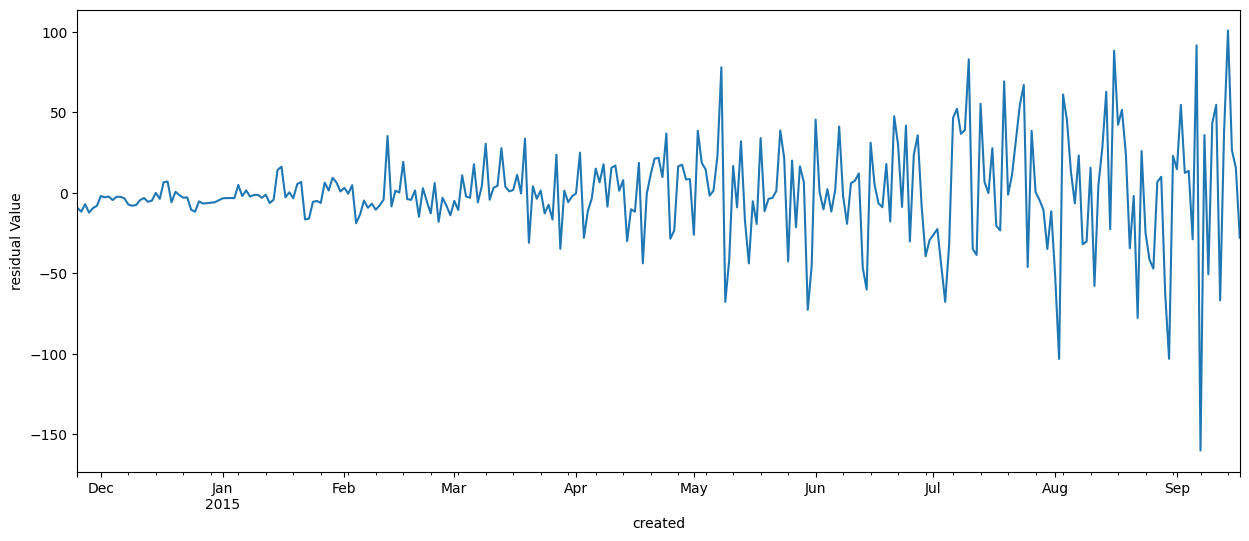

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="residual Value", ax=ax);

This plot reveals that there is no trend in the residuals, and this is a good sgin.

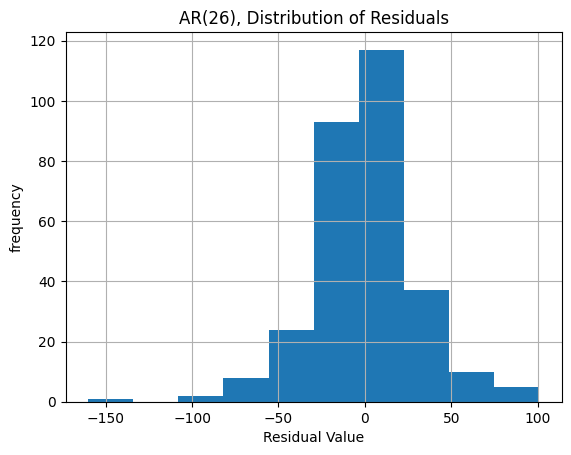

In [ ]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("frequency")
plt.title("AR(26), Distribution of Residuals");

Distribution of residuals is a normal distribution, which is beneficial because it indicates that the errors or differences between predicted and actual values are randomly distributed and follow a symmetric pattern around the mean. This assumption is crucial for many statistical models, including linear regression, as it suggests that the model captures most of the information in the data and that there are no systematic errors remaining.

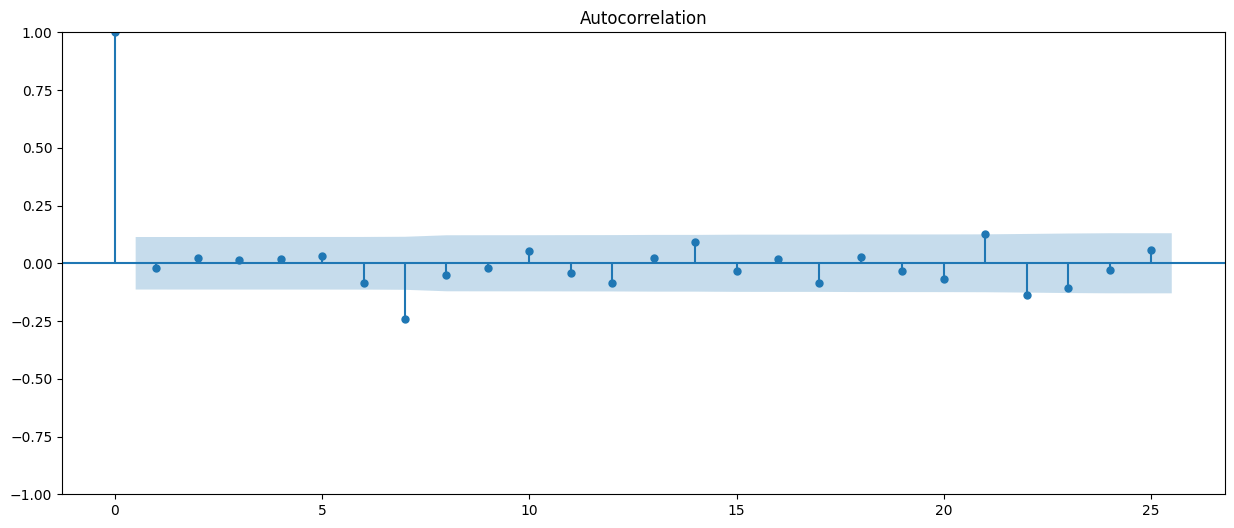

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

In the ACF plot for residuals, we observe that there is no significant autocorrelation beyond the lag of 0. This absence of high correlation at other lags suggests that the residuals are independent of each other and do not exhibit any systematic patterns over time. This is favorable because it indicates that the model has adequately captured the underlying patterns in the data, leaving minimal unexplained variance in subsequent time periods

**Evaluate:AutoReg**

In [ ]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 52.9190638525709


In [ ]:
def plot_predictions(y_test, y_pred_test):
  """
  Plot the actual and predicted values for the test set.

  This function creates a line plot that visualizes the actual (true) values
  and the predicted values for the test set. It helps to compare how well the
  model's predictions match the actual data.

  Parameters:
  y_test (pd.Series): The actual values of the target variable for the test set.
  y_pred_test (pd.Series): The predicted values of the target variable for the test set.
  """

  df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
    )

  fig = px.line(df_pred_test, labels={"value": "Kwh"})
  fig.show()
  return df_pred_test

AutoReg_plot = plot_predictions(y_test, y_pred_test)

**ARIMA Model**

In [ ]:
p_params = range(0, 7, 1)
q_params = range(0, 3, 1)

# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.38 seconds.
Trained ARIMA (0, 0, 1) in 0.8 seconds.
Trained ARIMA (0, 0, 2) in 0.71 seconds.
Trained ARIMA (1, 0, 0) in 0.45 seconds.
Trained ARIMA (1, 0, 1) in 1.08 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Trained ARIMA (1, 0, 2) in 1.28 seconds.
Trained ARIMA (2, 0, 0) in 0.68 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (2, 0, 1) in 2.08 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (2, 0, 2) in 3.21 seconds.
Trained ARIMA (3, 0, 0) in 1.66 seconds.
Trained ARIMA (3, 0, 1) in 4.04 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (3, 0, 2) in 4.62 seconds.
Trained ARIMA (4, 0, 0) in 1.58 seconds.
Trained ARIMA (4, 0, 1) in 4.4 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (4, 0, 2) in 6.58 seconds.
Trained ARIMA (5, 0, 0) in 1.82 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (5, 0, 1) in 5.15 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (5, 0, 2) in 3.85 seconds.
Trained ARIMA (6, 0, 0) in 1.64 seconds.
Trained ARIMA (6, 0, 1) in 3.73 seconds.
Trained ARIMA (6, 0, 2) in 5.25 seconds.

{0: [54.504826061838514, 39.02983499110344, 34.580808630533824], 1: [29.330210861393347, 29.308504671506853, 24.904039373518202], 2: [29.279993172616663, 29.276611138140076, 24.893751809867382], 3: [28.674874746456442, 24.669505349808052, 27.812272277432086], 4: [28.320789548424194, 24.478115754252475, 27.550692826126376], 5: [26.720496347030167, 23.29140591964582, 22.338304080937082], 6: [23.115529464549148, 21.450126150939933, 19.89262587578521]}


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



here I'm making a grid search to see the best hyperparameters for the ARIMA, I used a range of lags between 0 and 7, and number of lagged forecast errors between 0 and 3.

In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2,3,4,5,6
0,54.5048,29.3302,29.2800,28.6749,28.3208,26.7205,23.1155
1,39.0298,29.3085,29.2766,24.6695,24.4781,23.2914,21.4501
2,34.5808,24.9040,24.8938,27.8123,27.5507,22.3383,19.8926


Text(0.5, 1.0, 'ARMA grid search(critertion: MAE)')

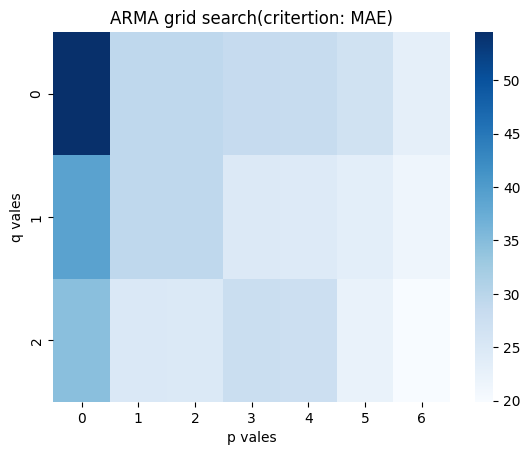

In [ ]:
sns.heatmap(mae_df, cmap="Blues")
plt.xlabel("p vales")
plt.ylabel("q vales")
plt.title("ARMA grid search(critertion: MAE)")

best performance is for p = 6 and q = 2

**Evaluate: ARMA**

In [ ]:
y_pred_wfv = pd.Series(dtype=float)
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(6, 0, 2)).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test[next_pred.index]])

test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3

Test MAE (walk forward validation): 44.12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
ARIMA_plot = plot_predictions(y_test, y_pred_wfv)

# Attemp 2: linear regression,XGBoost and Random forest (using lags and other features)

**Feature Engineering**

In [ ]:
df_resampled = df_resampled.to_frame()
df_resampled.head()

,kwhTotal
created,
2014-11-18,13.39
2014-11-19,18.77
2014-11-20,6.95
2014-11-21,14.14
2014-11-22,0.00


In [ ]:

df_resampled['chargeTimeHrs_daily'] = df_masked['chargeTimeHrs'].resample('D').sum()

zero_chargeTimeHrs = df_resampled[df_resampled['chargeTimeHrs_daily'] == 0]
zero_chargeTimeHrs_count = zero_kwh_total.count()
print(f"Number of days with zero chargetime: {zero_kwh_count}")

Number of days with zero chargetime: 85


In [ ]:
# Impute the chargeTimeHrs with the mean vakue

chargeTime_mean = df_resampled['chargeTimeHrs_daily'].mean()

df_filled = df_resampled['chargeTimeHrs_daily'].fillna(chargeTime_mean)
zero_charge_time = df_filled[df_filled == 0]
df_filled[zero_charge_time.index] = chargeTime_mean

df_filled

created
2014-11-18      4.923611
2014-11-19      5.317500
2014-11-20      2.455278
2014-11-21      7.154722
2014-11-22     29.844709
                 ...    
2015-09-30    130.756111
2015-10-01    122.765000
2015-10-02     75.304167
2015-10-03      6.903333
2015-10-04      3.151944
Freq: D, Name: chargeTimeHrs_daily, Length: 321, dtype: float64

After resampling the 'chargeTimeHrs' column, missing values were expected. To address this, I used the sample mean instead of a rolling mean, as charge time hours do not depend on previous values. Thus, the mean is a more appropriate choice for imputation

In [ ]:
df_resampled['chargeTimeHrs_daily'] = df_filled
df_resampled.head()

,kwhTotal,chargeTimeHrs_daily
created,,
2014-11-18,13.39,4.923611
2014-11-19,18.77,5.317500
2014-11-20,6.95,2.455278
2014-11-21,14.14,7.154722
2014-11-22,0.00,29.844709


In [ ]:
# Add a weekday column to the resampled data
df_resampled['weekday'] = df_resampled.index.weekday

# One-hot encode the weekday column
df_resampled = pd.concat([df_resampled, pd.get_dummies(df_resampled['weekday'], prefix='weekday').astype(int)], axis=1)

# Drop the original 'weekday' column as it is no longer needed
df_resampled.drop('weekday', axis=1, inplace=True)
df_resampled.head()

,kwhTotal,chargeTimeHrs_daily,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
created,,,,,,,,,
2014-11-18,13.39,4.923611,0,1,0,0,0,0,0
2014-11-19,18.77,5.317500,0,0,1,0,0,0,0
2014-11-20,6.95,2.455278,0,0,0,1,0,0,0
2014-11-21,14.14,7.154722,0,0,0,0,1,0,0
2014-11-22,0.00,29.844709,0,0,0,0,0,1,0


In [ ]:
lags = 7  # Example: Use 7 lags

for i in range(1, lags+1):
    df_resampled[f'lag_{i}'] = df_resampled['kwhTotal'].shift(i)

# Additional features (if any)
# Example: Assuming X_features is a DataFrame with additional features
# Merge with lagged features
df_final = pd.concat([df_resampled[['kwhTotal', 'chargeTimeHrs_daily']], df_resampled[['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']], df_resampled[[f'lag_{i}' for i in range(1, lags + 1)]]], axis=1).dropna()

# Split into target (y) and predictors (X)
y = df_final['kwhTotal']
X = df_final.drop(columns=['kwhTotal'])

In [ ]:
X.shape

(314, 15)

**Split the data after adding more columns**

In [ ]:
cutoff_test = int(len(df_filled) * 0.90)
X_train = X.iloc[:cutoff_test]
X_test = X.iloc[cutoff_test:]

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

print(f"y Training set size: {len(y_train)}")
print(f"y Test set size: {len(y_test)}")
print(f"X Training set size: {len(X_train)}")
print(f"X Test set size: {len(X_test)}")

y Training set size: 288
y Test set size: 26
X Training set size: 288
X Test set size: 26


**Linear Regression Model**

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

**Evalueate: linearRegression**

In [ ]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 14.38
Test MAE: 15.3


In [ ]:
y_pred_test = model.predict(X_test)
linearResgression_plot = plot_predictions(y_test, y_pred_test)

**XGBoost Model**

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

training_mae = mean_absolute_error(y_train, model.predict(X_train))
# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Training MAE:", round(training_mae, 2))
mse = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Training MAE: 0.0
Mean Squared Error: 10.976213300961716


In [ ]:
XGBoost_plot = plot_predictions(y_test, y_pred)

**Random forest Model**

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the predictions
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 10.100934615384602


In [ ]:
RandomForest_plot = plot_predictions(y_test, y_pred)

**hyperparameter tuning**

In [ ]:
#Define the model
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)


print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Absolute Error (MAE): 10.092932528225285


Trying different hyperparameters and get the best model. hyperparameters like number of estimators and max_depth.

Best model with Parameters: max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100.

In [ ]:
RandomForest_plot = plot_predictions(y_test, y_pred)

#Model Comparison

To determine the most suitable model for forecasting the total energy consumption, I implemented and evaluated multiple models: AutoReg, ARIMA, Linear Regression, XGBoost, and Random Forest. Each model was trained and tested on the same dataset, and their performance was assessed using the Mean Absolute Error (MAE) metric. The MAE provides a measure of how close the predictions are to the actual values, with a lower MAE indicating better performance.

I compiled the performance metrics into a comparison table. This table summarizes the training and testing MAE for each model, allowing us to easily identify which model performed best on the test data

In [ ]:
# Create a DataFrame with model performance
comparison_df = pd.DataFrame({ 'Model': ['AutoReg', 'ARIMA', 'Linear Regression', 'XGBoost', 'Random Forest', 'Random Forest (Tuned)'], 'Training MAE': [20.0671, 19.8926, 14.38, None, None, None], 'Test MAE': [52.9191, 44.12, 15.3, 10.9762, 10.1009, 10.0929] })
# Display the comparison table
comparison_df

,Model,Training MAE,Test MAE
0,AutoReg,20.0671,52.9191
1,ARIMA,19.8926,44.1200
2,Linear Regression,14.3800,15.3000
3,XGBoost,NaN,10.9762
4,Random Forest,NaN,10.1009
5,Random Forest (Tuned),NaN,10.0929


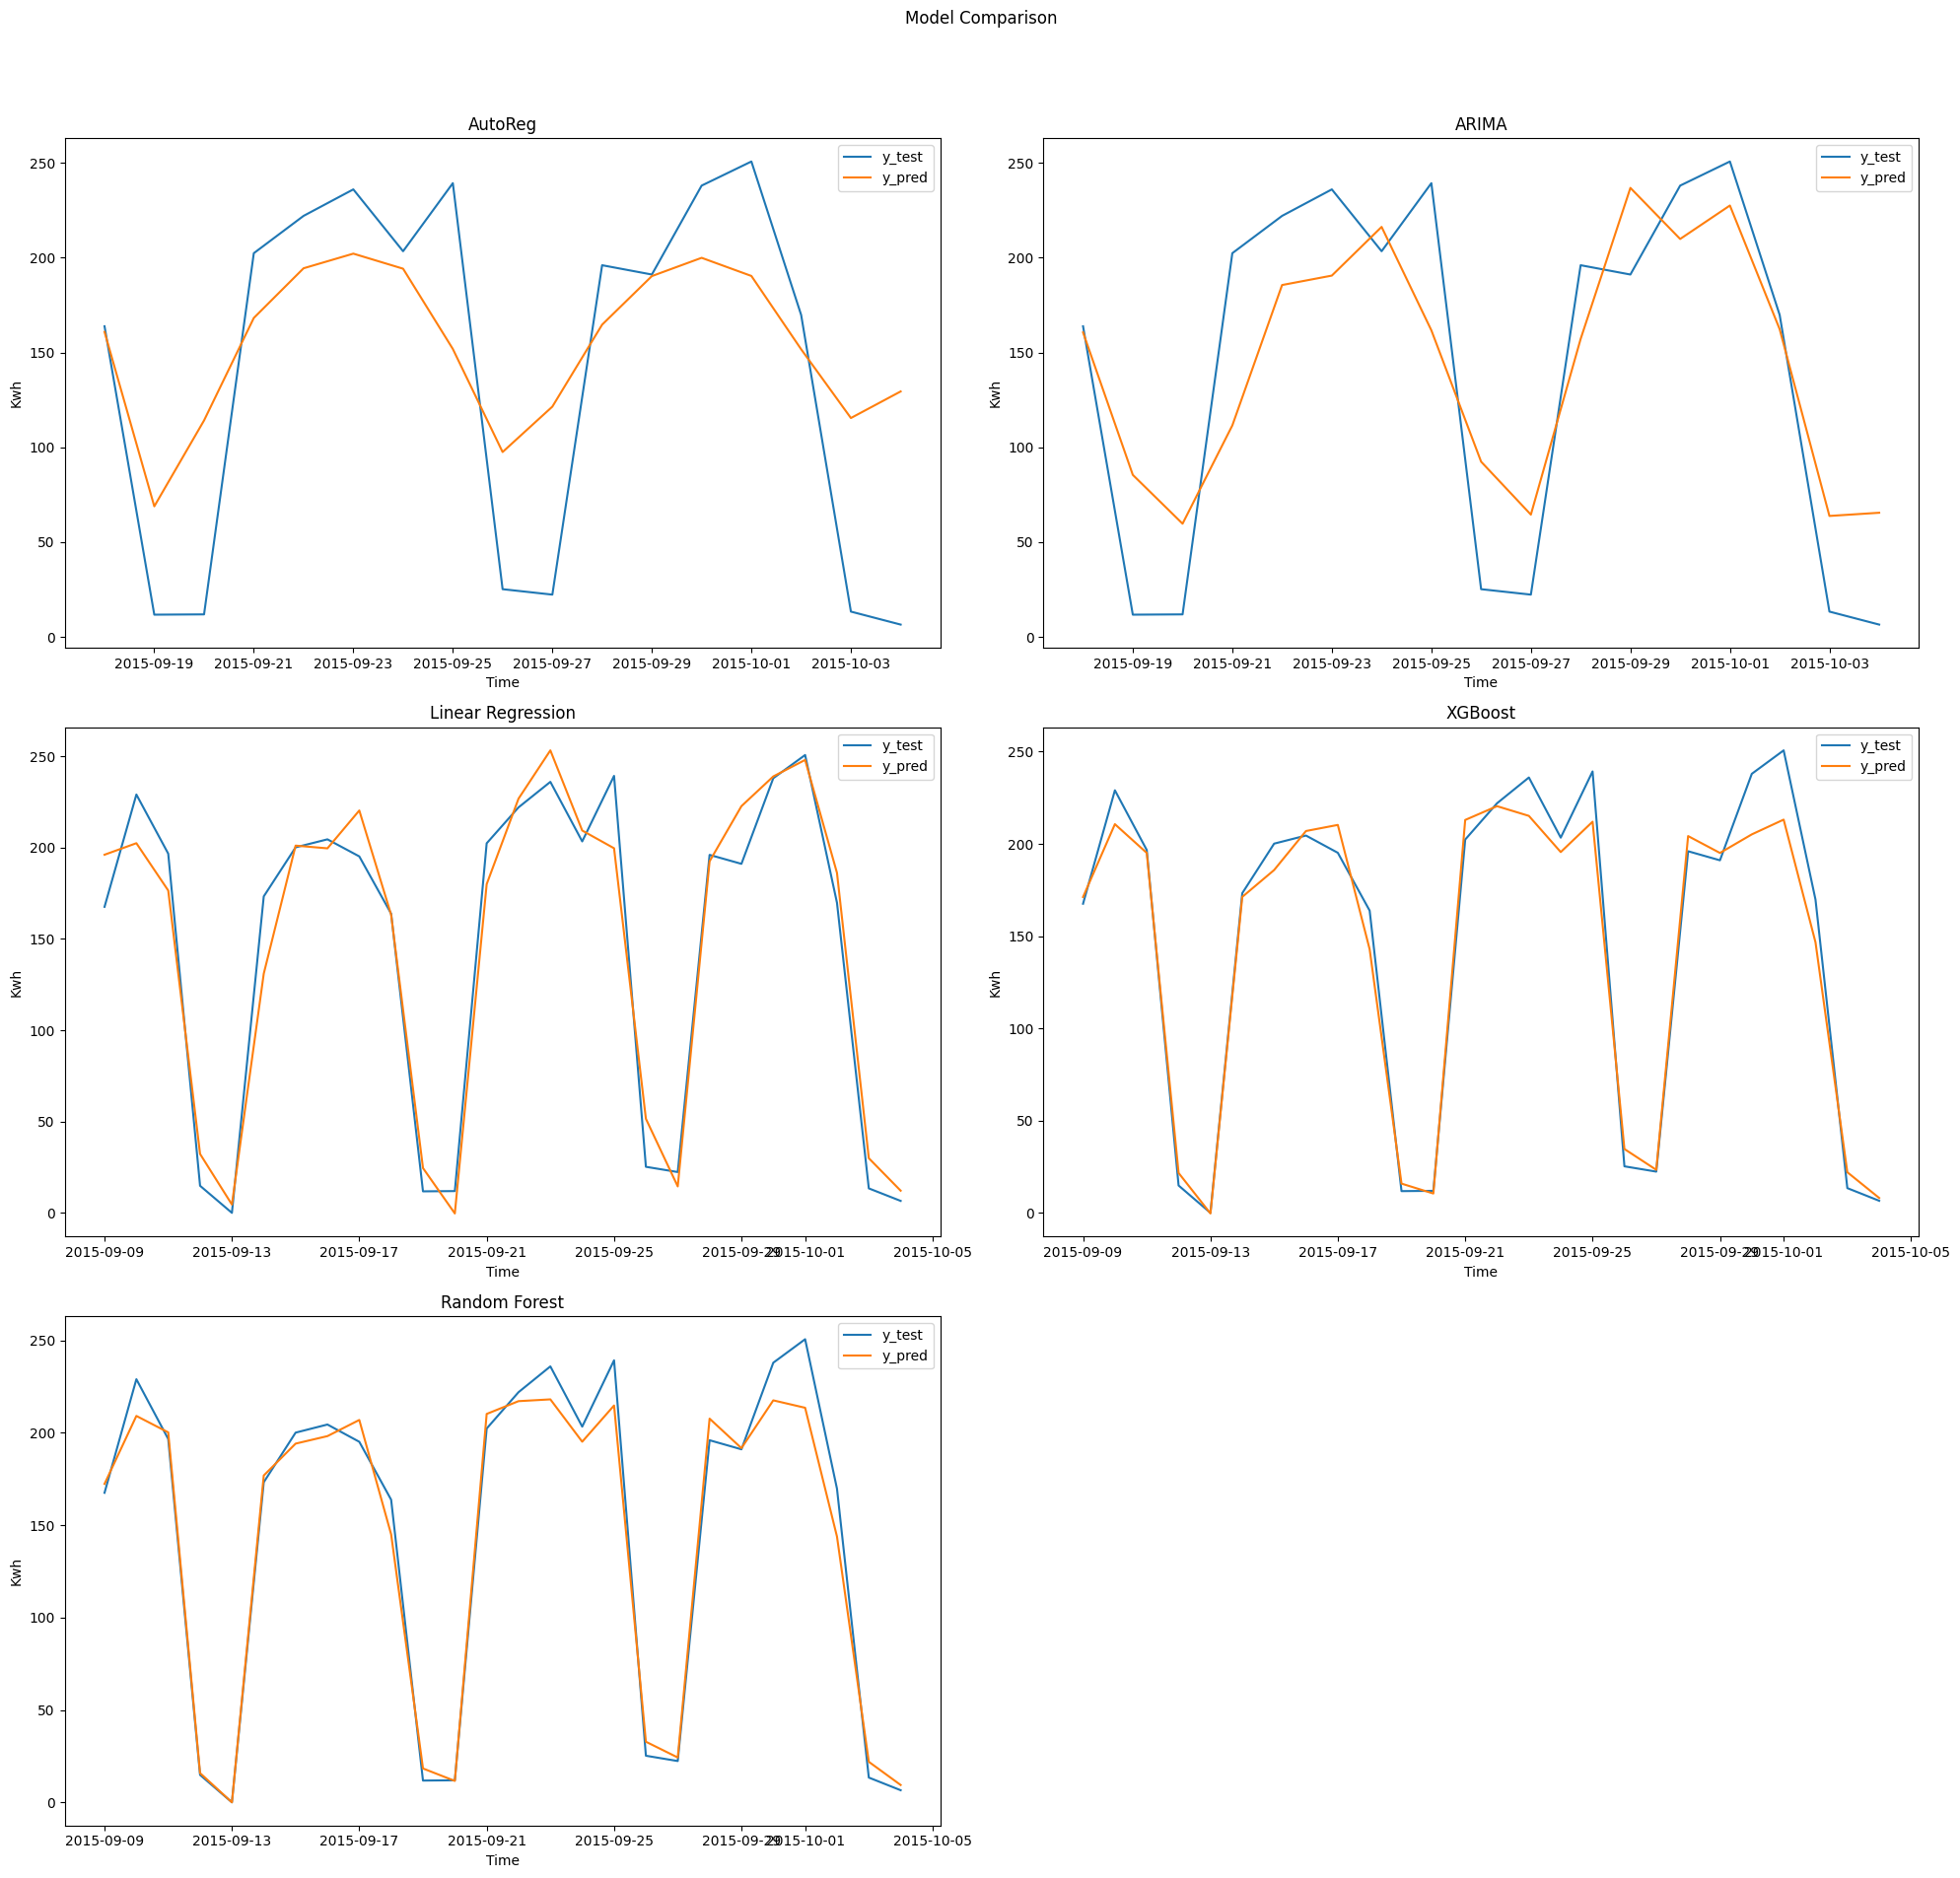

In [ ]:
`used_models_data = [AutoReg_plot, ARIMA_plot, linearResgression_plot, XGBoost_plot, RandomForest_plot]

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle('Model Comparison')

# List of titles for the subplots
titles = ['AutoReg', 'ARIMA', 'Linear Regression', 'XGBoost', 'Random Forest']
label= ['y_test','y_pred']

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, data, title in zip(axes, used_models_data, titles):
    ax.plot(data.index, data.values, label=label)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Kwh')
    ax.legend()

# Turn off the last subplot if you have an extra one
if len(axes) > len(used_models_data):
    axes[-1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show();


**Final Thoughts**

**1. Model Performance Review:**

* **Initial Models:** The initial models, AutoReg and ARIMA, provided a baseline for our analysis. However, due to the non-stationarity of the data, these models did not perform as well as anticipated.

* **Enhanced Models:** By incorporating additional features such as day of the week and charge time into more sophisticated models like Linear Regression, XGBoost, and Random Forest, we observed a notable improvement in prediction accuracy. This indicates that including relevant features can significantly enhance the model’s performance.

**2. Feature Engineering:**

* **Feature Importance:** The correlation matrix was instrumental in identifying the most relevant features for our models. Features such as charge time weas crucial in improving the accuracy of our predictions.

* **Handling Missing Data:** The choice of filling missing values with a 7-day rolling mean was appropriate given the seasonal nature of the data. However, I recommend experimenting with different rolling mean windows. Keep in mind that smaller windows (e.g., 3 days) may capture more short-term fluctuations but introduce more noise, while larger windows (e.g., 14 or 30 days) may smooth out the data too much.

**3. Model Selection:**

* **Model Comparison:** Through rigorous comparison, Linear Regression emerged as the best performer among the models tested. It effectively captured the underlying patterns in the data, including the weekly seasonality.

* **Model Optimization:** Hyperparameter tuning via Grid Search was critical in optimizing the Random Forest model(did not make a huge differance). Employing more advanced techniques like Bayesian Optimization could yield even better results.

**4. Time Series Specific Considerations:**

* **Seasonality and Trend Analysis:** Conducting a deeper seasonal decomposition of the time series could provide more insights into the long-term trends and seasonal effects, potentially leading to better feature engineering.

* **Stationarity:** Addressing the non-stationarity in the data remains a challenge. Transformations such as differencing or using logarithmic scales can help stabilize the mean and variance, making the data more suitable for certain time series models(if you want to try this teqniqe you can try it with ARIMA but I don't see it will led to better results).

**5. Potential Improvements:**

* **Model Ensemble:** Creating an ensemble of multiple models might capture different aspects of the data more effectively, leading to improved predictions.
* **Deep Learning Models:** Exploring advanced models like LSTM (Long Short-Term Memory) networks or GRU (Gated Recurrent Units) could be beneficial, especially if more data becomes available.(NOTE: I put this note for you in future work not in this dataset, as its so small data and deap learning models typically require more data to perform well. so you can try it in the future if the data is big enough).

* **Prophet Model:** Consider using models like Prophet, which are specifically designed for forecasting time series data with strong seasonal effects. Prophet is robust to missing data and shifts in the trend, making it a suitable candidate for this dataset, especially if more data becomes available.

* **Data Augmentation:** If feasible, collecting more data would significantly improve model training and validation. More data can help in capturing a broader range of patterns and reducing overfitting.

* **Start Time Analysis:** Instead of using the end time of charging sessions, consider analyzing the start time. This might provide different insights into usage patterns and could potentially improve model performance.

* **Incorporate the 'Distance' Column:** The 'distance' column has shown a strong correlation with the target variable, KwhTotal. Despite its potential, it was not used in the current model due to a high number of missing values. Addressing the missing values through imputation or collecting this data more comprehensively could enhance model performance.


**Conclusion:**

The analysis conducted has laid a solid foundation for forecasting the total kWh consumption for electric vehicle charging. While the models developed show promising results, there is always room for improvement. By incorporating more features, optimizing models further, and ensuring high-quality data, we can enhance the accuracy and reliability of our predictions. Continuous monitoring and iterative improvement will be key to achieving the best outcomes. Additionally, exploring the use of models like Prophet and analyzing the start time of charging sessions could offer new perspectives and potentially lead to better forecasting results.